# Sprint 深層学習スクラッチ 畳み込みニューラルネットワーク2

## 1.このSprintについて

**Sprintの目的**
- スクラッチを通してCNNの基礎を理解する

**どのように学ぶか**

スクラッチで2次元用畳み込みニューラルネットワークを実装した後、学習と検証を行なっていきます。

## 2.2次元の畳み込みニューラルネットワークスクラッチ

2次元に対応した畳み込みニューラルネットワーク（CNN）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


プーリング層なども作成することで、CNNの基本形を完成させます。クラスの名前はScratch2dCNNClassifierとしてください。



**データセットの用意**

引き続きMNISTデータセットを使用します。2次元畳み込み層へは、28×28の状態で入力します。


今回は白黒画像ですからチャンネルは1つしかありませんが、チャンネル方向の軸は用意しておく必要があります。


(n_samples, n_channels, height, width)のNCHWまたは(n_samples, height, width, n_channels)のNHWCどちらかの形にしてください。

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from keras.datasets import fashion_mnist
from sklearn.preprocessing import OneHotEncoder

## 【問題1】2次元畳み込み層の作成

1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。

## 【問題2】2次元畳み込み後の出力サイズ
畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。

In [2]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma

    def W(self, *shape):
        """
        重みの初期化
        """
        # 各種shapeに対応できるよう改造(n_nodes1, n_nodes2)⇒(*shape)
        W = self.sigma * np.random.randn(*shape)
        return W

    def B(self, *shape):
        """
        バイアスの初期化
        """
        # 各種shapeに対応できるよう改造(n_nodes2, )⇒(*shape)
        B = self.sigma * np.random.randn(*shape)
        return B

In [3]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return

In [4]:
class Conv2d:
    """
    2次元畳み込み層クラス  
    """
    def __init__(self, f_size, initializer, optimizer, n_in_channels=1, n_out_channels=1, padding=[0, 0], stride=[1, 1]):

        self.f_size_h = f_size[0] # フィルタのサイズ(高さ)
        self.f_size_w = f_size[1] # フィルタのサイズ(幅)

        self.pa_h = padding[0] # パディングの数(高さ)
        self.pa_w = padding[1] # パディングの数(幅)

        self.st_h = stride[0] # ストライドのサイズ(高さ)
        self.st_w = stride[1] # ストライドのサイズ(幅)

        self.optimizer = optimizer # 重みの初期化
        self.W = initializer.W(n_out_channels, n_in_channels, self.f_size_h, self.f_size_w) # 重み
        self.B = initializer.B(n_out_channels) # バイアス
        
        self.n_in_channels = n_in_channels # 入力チャンネル数
        self.n_out_channels = n_out_channels # 出力チャンネル数


    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 入力, shape (サンプル数, 入力チャネル数, 入力特徴量高さ、入力特徴量幅)
            
        Returns
        ----------
        A : 出力, shape (サンプル数, 出力チャンネル数, 出力特徴量高さ, 出力特徴量幅)
        """
        self.n_samples = X.shape[0] # サンプル数
        self.n_in_h = X.shape[-2] # 入力特徴量高さ
        self.n_in_w = X.shape[-1] # 入力特徴量幅
        self.n_out_h = out_size_calc(self.n_in_h, self.f_size_h, self.pa_h, self.st_h)  # 出力特徴量高さ
        self.n_out_w = out_size_calc(self.n_in_w, self.f_size_w, self.pa_w, self.st_w)  # 出力特徴量幅
        
        X = X.reshape(self.n_samples, self.n_in_channels, self.n_in_h, self.n_in_w) # Xのshapeを整える

        # (0,0),(0,0)サンプル数次元, self.pa_h/self.pa_w入力チャネル数次元上下/左右
        self.X = np.pad(X, ((0,0),(0,0), (self.pa_h,self.pa_h), (self.pa_w,self.pa_w)))
        # print('self.X', self.X, sep='\n')

        # Aの値を入れる箱を作っておく（サンプル数, 出力チャンネル数, 出力特徴量数）
        A = np.zeros((self.n_samples, self.n_out_channels, self.n_out_h, self.n_out_w))
        for n_sam in range(self.n_samples): # サンプル数
            for n_out_ch in range(self.n_out_channels): # 出力チャンネル数
                for n_out_h in range(self.n_out_h): # 出力特徴量高さ
                    for n_out_w in range(self.n_out_w): # 出力特徴量幅
                        for n_in_ch in range(self.n_in_channels): # 入力チャネル数
                            for f_size_h in range(self.f_size_h): # フィルターのサイズ高さ
                                for f_size_w in range(self.f_size_w): # フィルターのサイズ幅
                                    A[n_sam, n_out_ch, n_out_h, n_out_w] += \
                                    self.X[n_sam, n_in_ch, n_out_h*self.st_h+f_size_h,  n_out_w*self.st_w+f_size_w]\
                                    *self.W[n_out_ch, n_in_ch, f_size_h, f_size_w]
                                    # print('A', A)
                    A[n_sam, n_out_ch, n_out_h, n_out_w] += self.B[n_out_ch]

        return A

    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA :後ろから流れてきた勾配, shape (サンプル数, 出力チャンネル数, 出力特徴量高さ, 出力特徴量幅)
            
        Returns
        ----------
        dX : 前に流す勾配, shape (サンプル数, 入力チャネル数, 入力特徴量高さ、入力特徴量幅)
        """
        # dW,dBの値を入れる箱を作っておく
        self.dW = np.zeros(self.W.shape) # (n_out_channels, n_in_channels, self.f_size_h, self.f_size_w)
        self.dB = np.zeros(self.B.shape)# (n_out_channels)

        for n_sam in range(self.n_samples): # サンプル数
            for n_out_ch in range(self.n_out_channels): # 出力チャンネル数
                for n_out_h in range(self.n_out_h): # 出力特徴量高さ
                    for n_out_w in range(self.n_out_w): # 出力特徴量幅
                        for n_in_ch in range(self.n_in_channels): # 入力チャネル数
                            for f_size_h in range(self.f_size_h): # フィルターのサイズ高さ
                                for f_size_w in range(self.f_size_w): # フィルターのサイズ幅
                                    self.dW[n_out_ch, n_in_ch, f_size_h, f_size_w] += \
                                    dA[n_sam, n_out_ch, n_out_h, n_out_w]\
                                    *self.X[n_sam, n_in_ch, n_out_h*self.st_h+f_size_h,  n_out_w*self.st_w+f_size_w]
                                    # print('self.dW', self.dW, sep='\n')
                                    # print('-----------------------------------')
                        self.dB[n_out_ch] += dA[n_sam, n_out_ch, n_out_h, n_out_w]
                        # print('self.dB', self.dB, sep='\n')
                        # print('-----------------------------------')

        # dXの値を入れる箱を作っておく
        dX = np.zeros(self.X.shape)
        # print('dX', dX)
        # print('dX.shape', dX.shape)
        for n_sam in range(self.n_samples): # サンプル数
            for n_in_ch in range(self.n_in_channels): # 入力チャネル数
                for n_in_h in range(self.n_in_h): # 入力特徴量高さ
                    for n_in_w in range(self.n_in_w): # 入力特徴量幅
                        for n_out_ch in range(self.n_out_channels): # 出力チャンネル数
                            for f_size_h in range(self.f_size_h): # フィルターのサイズ高さ
                                for f_size_w in range(self.f_size_w): # フィルターのサイズ幅
                                    if 0 <= n_in_h - f_size_h <= self.n_out_h - 1 and 0 <= n_in_w - f_size_w <= self.n_out_w - 1:
                                        dX[n_sam, n_in_ch, n_in_h, n_in_w] += \
                                        dA[n_sam, n_out_ch, n_in_h - f_size_h, n_in_w - f_size_w]\
                                        *self.W[n_out_ch, n_in_ch, f_size_h, f_size_w]
                                        # print('self.dX', self.dX, sep='\n')
                                        # print('-----------------------------------')

        # 更新
        self.optimizer.update(self)
        return dX

In [5]:
    # 【問題3】2次元畳み込み後の出力サイズの計算
    def out_size_calc(n_in, f_size, padding=0, stride=1):
        """
        2次元畳み込み後の出力サイズの計算
        """
        # 問題3式通り
        n_out = (n_in + 2*padding - f_size) / stride + 1
        return int(n_out) # 上の式の結果がfloatになるため、整数intにする

一旦適当なデータでテスト

In [6]:
conv2d_test = Conv2d(f_size=[3, 3], initializer=SimpleInitializer(0.01), \
                     optimizer=SGD(0.01), n_in_channels=1, n_out_channels=1, padding=[0, 0])

In [7]:
# テストデータshape(2, 1, 6, 6)（サンプル数, 入力チャネル数, 入力特徴量高さ、入力特徴量幅）
x = np.array([[[[1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6], \
                [1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6]]], [[[2, 3, 4, 5, 6, 7], [2, 3, 4, 5, 6, 7], \
                [2, 3, 4, 5, 6, 7], [2, 3, 4, 5, 6, 7], [2, 3, 4, 5, 6, 7], [2, 3, 4, 5, 6, 7]]]])
print(x)
print(x.shape)

[[[[1 2 3 4 5 6]
   [1 2 3 4 5 6]
   [1 2 3 4 5 6]
   [1 2 3 4 5 6]
   [1 2 3 4 5 6]
   [1 2 3 4 5 6]]]


 [[[2 3 4 5 6 7]
   [2 3 4 5 6 7]
   [2 3 4 5 6 7]
   [2 3 4 5 6 7]
   [2 3 4 5 6 7]
   [2 3 4 5 6 7]]]]
(2, 1, 6, 6)


In [8]:
# フォワードプロパゲーション
a = conv2d_test.forward(x)
print('----------------------------')
print('a', a)
print('----------------------------')
print('a.shape', a.shape)

----------------------------
a [[[[-0.01703969 -0.02881629 -0.04059288 -0.06260705]
   [-0.01703969 -0.02881629 -0.04059288 -0.06260705]
   [-0.01703969 -0.02881629 -0.04059288 -0.06260705]
   [-0.01703969 -0.02881629 -0.04059288 -0.06260705]]]


 [[[-0.02881629 -0.04059288 -0.05236948 -0.07438365]
   [-0.02881629 -0.04059288 -0.05236948 -0.07438365]
   [-0.02881629 -0.04059288 -0.05236948 -0.07438365]
   [-0.02881629 -0.04059288 -0.05236948 -0.07438365]]]]
----------------------------
a.shape (2, 1, 4, 4)


In [9]:
# バックプロパゲーション
delta_a = np.array([[[[1, 1, 2, 2, 3, 3], [1, 1, 2, 2, 3, 3], [1, 1, 2, 2, 3, 3], [1, 1, 2, 2, 3, 3], \
                [1, 1, 2, 2, 3, 3], [1, 1, 2, 2, 3, 3]]], [[[4, 4, 5, 5, 6, 6], [4, 4, 5, 5, 6, 6], \
                [4, 4, 5, 5, 6, 6], [4, 4, 5, 5, 6, 6], [4, 4, 5, 5, 6, 6], [4, 4, 5, 5, 6, 6]]]])
delta_x = conv2d_test.backward(delta_a)
print('----------------------------')
print('delta_x', delta_x)
print('----------------------------')
print('delta_x.shape', delta_x.shape)

----------------------------
delta_x [[[[-7.56218807e-03 -1.18358373e-02 -1.43405941e-02 -1.86142433e-02
     1.56756416e-03  1.01148627e-02]
   [-4.09026991e-03 -8.48163574e-03 -7.42251170e-03 -1.18138775e-02
     1.51605625e-03  1.02987879e-02]
   [-8.30693238e-05 -1.82070352e-02 -1.18596672e-02 -2.99836330e-02
    -2.33870571e-02  1.28608745e-02]
   [-8.30693238e-05 -1.82070352e-02 -1.18596672e-02 -2.99836330e-02
    -2.33870571e-02  1.28608745e-02]
   [ 7.47911874e-03 -6.37119782e-03  2.48092684e-03 -1.13693897e-02
    -2.49546213e-02  2.74601183e-03]
   [ 4.00720059e-03 -9.72539941e-03 -4.43715551e-03 -1.81697555e-02
    -2.49031134e-02  2.56208662e-03]]]


 [[[-3.02487523e-02 -4.73433493e-02 -3.46758120e-02 -3.89494613e-02
     3.91891041e-03  2.52871568e-02]
   [-1.63610797e-02 -3.39265430e-02 -1.74192371e-02 -2.18106029e-02
     3.79014063e-03  2.57469698e-02]
   [-3.32277295e-04 -7.28281406e-02 -4.71894609e-02 -6.53134267e-02
    -5.84676428e-02  3.21521863e-02]
   [-3.3227729

(参考サイト)[numpy.pad関数完全理解](https://qiita.com/kuroitu/items/51f4c867c8a44de739ec)

In [10]:
# pa_h = 1
# pa_w = 2
# np.pad(x, ((0,0),(0,0),(pa_h,pa_h),(pa_w,pa_w)))

In [11]:
# pa_h = 0
# pa_w = 1
# np.pad(x, ((0,0),(0,0),(pa_h,pa_h),(pa_w,pa_w)))

In [13]:
# pa_h = 1
# pa_w = 2
# np.pad(x, ((1,0),(0,0),(pa_h,pa_h),(pa_w,pa_w)))

## 【問題2】小さな配列での2次元畳み込み層の実験
次に示す小さな配列でフォワードプロパゲーションとバックプロパゲーションが正しく行えているか確認してください。


入力x、重みwを次のようにします。

In [14]:
# CNN2 のフォワードを流す時の入力データ
#(2,3,3)
#(1,1,4,4)
x = np.array([[[[ 1, 2, 3, 4],[ 5, 6, 7, 8],[ 9, 10, 11, 12],[13, 14, 15, 16]],],])
w = np.array([[[ 0., 0., 0.],[ 0., 1., 0.],[ 0., -1., 0.],],[[ 0., 0., 0.],[ 0., -1., 1.],[ 0., 0., 0.]]])
#(?,1,2,2,)

In [15]:
print(x)
print(x.shape)

[[[[ 1  2  3  4]
   [ 5  6  7  8]
   [ 9 10 11 12]
   [13 14 15 16]]]]
(1, 1, 4, 4)


In [16]:
print(w)
print(w.shape)

[[[ 0.  0.  0.]
  [ 0.  1.  0.]
  [ 0. -1.  0.]]

 [[ 0.  0.  0.]
  [ 0. -1.  1.]
  [ 0.  0.  0.]]]
(2, 3, 3)


In [17]:
conv2d_test02 = Conv2d(f_size=[3, 3], initializer=SimpleInitializer(0.01), \
                     optimizer=SGD(0.01), n_in_channels=1, n_out_channels=1, padding=[0, 0])

In [18]:
conv2d_test02.W = np.zeros((1, 2, 3, 3), dtype=float) 
conv2d_test02.W[0, 0, 1, 1] = 1
conv2d_test02.W[0, 0, 2, 1] = -1
conv2d_test02.W[0, 1, 1, 1] = -1
conv2d_test02.W[0, 1, 1, 2] = 1

conv2d_test02.W

array([[[[ 0.,  0.,  0.],
         [ 0.,  1.,  0.],
         [ 0., -1.,  0.]],

        [[ 0.,  0.,  0.],
         [ 0., -1.,  1.],
         [ 0.,  0.,  0.]]]])

In [19]:
# フォワードプロパゲーション
a = conv2d_test02.forward(x)
print('----------------------------')
print('a', a)
print('----------------------------')
print('a.shape', a.shape)

----------------------------
a [[[[-4.        -4.0151743]
   [-4.        -4.0151743]]]]
----------------------------
a.shape (1, 1, 2, 2)


In [20]:
# バックプロパゲーション
delta = np.array([[[-4,-4],[10,11],],[[1,-7],[1,-11],]])
delta_x = conv2d_test02.backward(delta_a)
print('delta_x', delta_x, sep='\n')
print('----------------------------')
print('delta_x.shape', delta_x.shape)

delta_x
[[[[ 0.  0.  0.  0.]
   [ 0.  1.  1.  0.]
   [ 0.  0.  0.  0.]
   [ 0. -1. -1.  0.]]]]
----------------------------
delta_x.shape (1, 1, 4, 4)


## 【問題4】最大プーリング層の作成
最大プーリング層のクラスMaxPool2Dを作成してください。

In [28]:
class MaxPool2D:
    """
    最大プーリング層のクラス
    """
    def __init__(self, stride):
        self.st_h = stride[0] # ストライドのサイズ(高さ)
        self.st_w = stride[1] # ストライドのサイズ(幅)
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 入力, shape (サンプル数, 入力チャネル数, 入力特徴量高さ、入力特徴量幅)
        """
        self.X = X
         # サンプル数, 入力チャネル数, 入力特徴量高さ、入力特徴量幅
        self.n_samples, self.n_in_channels, self.n_in_h, self.n_in_w = X.shape

        # Aの値を入れる箱を作っておく（サンプル数, 入力チャネル数, 出力特徴量数高さ, 出力特徴量数幅）
        A = np.zeros((self.n_samples, self.n_in_channels, self.n_in_h//self.st_h, self.n_in_w//self.st_w)) # 入力特徴量とストライドの切り捨て除算
        # print('A', A, sep='\n')
        # print('--------------------')
        # print('A.shape', A.shape)
        # print('--------------------')

        # 最大プーリングのインデックスを入れる箱を作っておく(入力特徴量高さ・幅の積とストライド高さ・幅の積の切り捨て除算)
        self.Aij = np.zeros(((self.n_in_h*self.n_in_w)//(self.st_h*self.st_w), X.ndim), dtype=int) 
        # print('self.Aij', self.Aij, sep='\n')
        # print('--------------------')
        # print('self.Aij.shape', self.Aij.shape)
        # print('--------------------')

        for n_sam in range(self.n_samples):
            for n_in_ch in range(self.n_in_channels):
                for i in range(self.n_in_h//self.st_h):
                    for j in range(self.n_in_w//self.st_w):
                        # プーリングのフィルターサイズ(2,2)ごとのXの値をX1に格納
                        X1 = X[n_sam, n_in_ch, i*self.st_h : (i +1)*self.st_h, j*self.st_w : (j +1)*self.st_w]
                        # print('X1', X1, sep='\n')
                        # print('--------------------')
                        # 最大値をAに格納
                        A[n_sam, n_in_ch, i, j] = np.max(X1)
                        # print('A', A)
                        # print('--------------------')
                        # 最大値のインデックスをidxに格納
                        idx = np.argmax(X1)
                        # print('idx', idx)
                        # print('--------------------')
                         # 最大プーリングのインデックスを入れる(入力特徴量高さ次元は切り捨て除算,入力特徴量幅次元は割ったあまり)
                        self.Aij[i*(self.n_in_w//self.st_w) + j] = \
                        np.array([n_sam, n_in_ch, i*self.st_h + idx//self.st_h, j*self.st_w + idx%self.st_h], dtype=int)
                        # print('self.Aij', self.Aij, sep='\n')
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA :後ろから流れてきた勾配, shape (サンプル数, 出力チャンネル数, 出力特徴量高さ, 出力特徴量幅)
            
        Returns
        ----------
        dX : 前に流す勾配, shape (サンプル数, 入力チャネル数, 入力特徴量高さ、入力特徴量幅)
        """
        # フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には0を入れる
        a = np.zeros(self.X.shape)
        a[tuple(self.Aij.T)] = 1
        return a*dA

In [29]:
# 小さなデータセットで動作確認
X = np.arange(1*1*6*8).reshape(1,1,6,8)
X

array([[[[ 0,  1,  2,  3,  4,  5,  6,  7],
         [ 8,  9, 10, 11, 12, 13, 14, 15],
         [16, 17, 18, 19, 20, 21, 22, 23],
         [24, 25, 26, 27, 28, 29, 30, 31],
         [32, 33, 34, 35, 36, 37, 38, 39],
         [40, 41, 42, 43, 44, 45, 46, 47]]]])

In [30]:
# print('X[0, 0, 1, 1] -> ', X[0, 0, 1, 1])
# print('X[0, 0, 1, 3] -> ', X[0, 0, 1, 3])

In [31]:
maxpool2d = MaxPool2D(stride=[2,2])

In [32]:
# フォワードプロパゲーション
maxpool2d.forward(X)

array([[[[ 9., 11., 13., 15.],
         [25., 27., 29., 31.],
         [41., 43., 45., 47.]]]])

In [33]:
# バックプロパゲーション
dA = np.arange(1*1*6*8).reshape(1,1,6,8)
dA

array([[[[ 0,  1,  2,  3,  4,  5,  6,  7],
         [ 8,  9, 10, 11, 12, 13, 14, 15],
         [16, 17, 18, 19, 20, 21, 22, 23],
         [24, 25, 26, 27, 28, 29, 30, 31],
         [32, 33, 34, 35, 36, 37, 38, 39],
         [40, 41, 42, 43, 44, 45, 46, 47]]]])

In [34]:
maxpool2d.backward(dA)

array([[[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  9.,  0., 11.,  0., 13.,  0., 15.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., 25.,  0., 27.,  0., 29.,  0., 31.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., 41.,  0., 43.,  0., 45.,  0., 47.]]]])

In [158]:
# maxpool2d.Aij.T

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 3, 3, 3, 3, 5, 5, 5, 5],
       [1, 3, 5, 7, 1, 3, 5, 7, 1, 3, 5, 7]])

In [159]:
# tuple(maxpool2d.Aij.T)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([1, 1, 1, 1, 3, 3, 3, 3, 5, 5, 5, 5]),
 array([1, 3, 5, 7, 1, 3, 5, 7, 1, 3, 5, 7]))

In [161]:
# a[tuple(maxpool2d.Aij.T)] = 1
# a

array([[[[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 1., 0., 1., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 1., 0., 1., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 1., 0., 1., 0., 1.]]]])

【問題5】（アドバンス課題）平均プーリングの作成

## 【問題6】平滑化

平滑化するためのFlattenクラスを作成してください。


フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。


この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。

In [35]:
class Flatten:
    """
    平滑化するためのクラス
    この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができる
    """
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 入力, shape (サンプル数, 出力チャネル数, 出力特徴量高さ、出力特徴量幅)

        Returns
        ----------
        A : 出力, shape (サンプル数, 出力チャンネル数*出力特徴量高さ*出力特徴量幅)
        """
        self.X_shape = X.shape #バックワードで使用
        # サンプル数だけ残してチャンネル、高さ、幅の3次元を1次元にreshape
        A = X.reshape(len(X), -1)       
        return A
    
    def backward(self, A):
        """
        バックワード
        Parameters
        ----------
        A : 入力, shape (サンプル数, 出力チャンネル数*出力特徴量高さ*出力特徴量幅)
            
        Returns
        ----------
        X : 元の形に戻す, shape (サンプル数, 出力チャネル数, 出力特徴量高さ、出力特徴量幅)
        """
        X = A.reshape(self.X_shape)
        return X

## 3.検証

## 【問題7】学習と推定
作成したConv2dを使用してMNISTを学習・推定し、Accuracyを計算してください。


精度は低くともまずは動くことを目指してください。

In [36]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.X = X        
        A = X@self.W + self.B # 線形変換
        return A

    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dB = np.sum(dA, axis=0)
        self.dW = self.X.T@dA
        dZ = dA@self.W.T

        # 更新
        self = self.optimizer.update(self)
        
        return dZ

In [37]:
class Sigmoid:
    """
    活性化関数 : 　シグモイド関数
    """
    def __init__(self):
        pass

    def forward(self, A):
        """
        フォワードプロパゲーションのときの処理
        """
        self.Z = 1 / (1 + np.exp(-A))
        return self.Z

    def backward(self, dZ):
        """
        バックプロパゲーションのときの処理
        """
        dA = dZ * (1 - self.Z) * self.Z
        return dA

In [38]:
class Tanh:
    """
    活性化関数 : 　ハイパボリックタンジェント関数
    """
    def __init__(self):
        pass

    def forward(self, A):
        """
        フォワードプロパゲーションのときの処理
        """
        self.Z = np.tanh(A)
        return self.Z

    def backward(self, dZ):
        """
        バックプロパゲーションのときの処理
        """
        dA = dZ * (1 - self.Z ** 2) 
        return dA

In [39]:
class Softmax:
    """
    活性化関数 : 　ソフトマックス関数
    """
    def __init__(self):
        pass

    def forward(self, A):
        """
        フォワードプロパゲーションのときの処理
        """
        c = np.max(A) # オーバーフロー対策
        self.Z = np.exp(A - c) / np.sum(np.exp(A - c), axis=1).reshape(-1,1)
        return self.Z

    def backward(self, Y):
        """
        バックプロパゲーションのときの処理
        """
        dA = self.Z - Y
        return dA

    def loss_func(self, Z, Y):
        """
        損失関数（目的関数）:交差エントロピー誤差
        """
        loss = -(Y * np.log(Z)).mean(axis=0).sum()
        return loss

In [40]:
class ReLU:
    """
    活性化関数 : 　ReLU関数
    """
    def __init__(self):
        pass

    def forward(self, A):
        """
        フォワードプロパゲーションのときの処理
        """
        self.A = A
        self.Z = np.maximum(A, 0)
        return self.Z

    def backward(self, dZ):
        """
        バックプロパゲーションのときの処理
        """
        dA = np.where(self.Z > 0, 1*dZ, 0)
        return dA

In [41]:
class XavierInitializer():
    """
    重みとバイアスの初期値 : シグモイド関数やハイパボリックタンジェント関数のとき
    """
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        W : shape(n_nodes1, n_nodes2)
        """
        self.sigma = 1 / np.sqrt(n_nodes1) # Xavierの初期値における標準偏差
        W = np.random.normal(0, self.sigma, (n_nodes1, n_nodes2)) 
        return W

    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        B : shape(n_nodes2, )
        """
        B = np.random.normal(0, self.sigma, n_nodes2) 
        return B

In [42]:
class HeInitializer():
    """
    重みとバイアスの初期値 : ReLU関数のとき
    """
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        W : shape(n_nodes1, n_nodes2)
        """
        self.sigma = np.sqrt(2 / n_nodes1) # Heの初期値における標準偏差
        W = np.random.normal(0, self.sigma, (n_nodes1, n_nodes2)) 
        return W

    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        B : shape(n_nodes2, )
        """
        B = np.random.normal(0, self.sigma, n_nodes2) 
        return B

In [43]:
class AdaGrad:
    """
    AdaGrad
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        self.HW = 0
        self.HB = 0
    
    def update(self, layer):
        self.HW += layer.dW ** 2
        self.HB += layer.dB ** 2
        layer.W -= self.lr * np.sqrt(1 / (self.HW + 1e-7)) * layer.dW # 1e-7加算は０除算防止のため
        layer.B -= self.lr * np.sqrt(1 / (self.HB + 1e-7)) * layer.dB # 1e-7加算は０除算のため

In [44]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [56]:
class Scratch2dCNNClassifier:
    """
    2次元の畳み込みニューラルネットワーク分類器
    ----------
    lr : 学習率
    batch_size : バッチサイズ   
    n_epoch : エポック数
    verbose : Trueの場合、学習曲線をプロット
    ----------
    """
    n_features, n_nodes1, n_nodes2, n_output = 784, 400, 200, 10
    
    def __init__(self, batch_size=20, n_epoch=5, lr=0.01, Activater=ReLU, \
                 Optimizer=AdaGrad, verbose=True):
        self.verbose = verbose
        self.batch_size = batch_size
        self.entropys = []
        self.val_entropys = []
        self.n_epoch = n_epoch
        self.lr = lr  # 学習率

        # 使う活性化関数によって重みやバイアスの初期値の分岐
        self.Activater = Activater
        if Activater == Sigmoid or Activater == Tanh:
            self.Initializer = XavierInitializer
        else:
            self.Initializer = HeInitializer

        # 最適化手法の選択
        self.Optimizer = Optimizer

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (サンプル数, 入力特徴量高さ、入力特徴量幅)
            学習用データの特徴量
        y : 次の形のndarray, shape (サンプル数, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (サンプル数, 入力特徴量高さ、入力特徴量幅)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (サンプル数, )
            検証用データの正解値
        """
        # Optimizer=AdaGradを想定し、FC毎にインスタンス化
        self.conv2d = Conv2d(f_size=[7, 7], initializer=SimpleInitializer(0.01), optimizer=self.Optimizer(self.lr), \
                            n_in_channels=1, n_out_channels=1, padding=[3, 3], stride=[2, 2])
        # 出力特徴量数(高さ)
        self.conv2d.n_out_h = out_size_calc(X.shape[-2], self.conv2d.f_size_h,\
                                                     self.conv2d.pa_h, self.conv2d.st_h)
        # 出力特徴量数(幅)
        self.conv2d.n_out_w = out_size_calc(X.shape[-1], self.conv2d.f_size_w,\
                                                     self.conv2d.pa_w, self.conv2d.st_w)
        self.flatten = Flatten()
        self.activation1 = self.Activater()
        self.FC2 = FC(1*self.conv2d.n_out_h*self.conv2d.n_out_w, self.n_nodes2, self.Initializer(), self.Optimizer(self.lr))
        self.activation2 = self.Activater()
        self.FC3 = FC(self.n_nodes2, self.n_output, self.Initializer(), self.Optimizer(self.lr))
        self.activation3 = Softmax()

        self.entropys = []  # 誤差を入れるリストを用意

        # yをone-hot表現に変換
        onehot_y = (y.reshape(-1, 1) == np.arange(self.n_output)).astype(np.float64)

        # バッチに分割
        get_mini_batch = GetMiniBatch(X, onehot_y, batch_size=self.batch_size) 

        # 検証用データが存在する場合
        if X_val is not None:
            # y_valをone-hot表現に変換
            onehot_y_val = (y_val.reshape(-1, 1) == np.arange(self.n_output)).astype(np.float64)
            # 交差エントロピー誤差を入れるリストを作っておく
            self.val_entropys = []

        # 学習開始(エポック数分繰り返す)
        for epoch in range(self.n_epoch):

            # ミニバッチの個数分ループ
            for mini_X_train, mini_y_train in get_mini_batch:

                # フォワードプロパゲーション
                self.forward(mini_X_train)

                # バックプロパゲーション
                dA3 = self.activation3.backward(mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dA1 = self.flatten.backward(dA1)
                dZ0 = self.conv2d.backward(dA1) # dZ0は使用しない
                
            # エントロピーを計算するためXを予測
            Z3 = self.forward(X)
            # 1サンプル毎の平均誤差をリストに格納
            self.entropys.append(self.activation3.loss_func(Z3, onehot_y)) 

            # 検証用データが存在する場合
            if X_val is not None:
                Z3_val = self.forward(X_val)
                self.val_entropys.append(
                    self.activation3.loss_func(Z3_val, onehot_y_val))

    def forward(self, X):
        """
        フォワードプロパゲーションの実装
        """
        # 《サンプルコード2》
        A1 = self.conv2d.forward(X)
        A1 = self.flatten.forward(A1)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return Z3

    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        y_pred = self.forward(X)
        return np.argmax(y_pred, axis=1)

In [52]:
# MNISTのデータセットを読み込み
import numpy as np
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0 

In [53]:
# 前処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [54]:
# 分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 28, 28)
print(X_val.shape) # (12000, 28, 28)
print(y_train.shape) # (48000,)
print(y_val.shape) # (12000,)

(48000, 28, 28)
(12000, 28, 28)
(48000,)
(12000,)


In [57]:
scratch_2dcnn = Scratch2dCNNClassifier() # インスタンス生成
scratch_2dcnn.fit(X_train, y_train, X_val, y_val) # 学習

In [58]:
y_pred = scratch_2dcnn.predict(X_val) # 推定

# Accuracyを計算
from sklearn.metrics import accuracy_score
print("Accuracy_score : ", accuracy_score(y_val, y_pred))

Accuracy_score :  0.9671666666666666


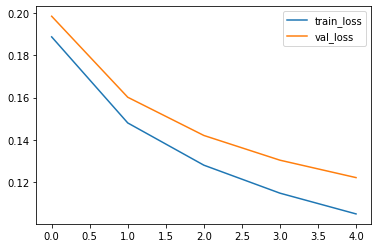

In [60]:
import matplotlib.pyplot as plt
plt.plot(scratch_2dcnn.entropys, label='train_loss')
plt.plot(scratch_2dcnn.val_entropys,label='val_loss')
plt.legend()
plt.show()

【問題8】（アドバンス課題）LeNet

【問題9】（アドバンス課題）有名な画像認識モデルの調査

## 【問題10】出力サイズとパラメータ数の計算

CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。


また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。


以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。

1.
- 入力サイズ : 144×144, 3チャンネル
- フィルタサイズ : 3×3, 6チャンネル
- ストライド : 1
- パディング : なし

**出力サイズ：142x142(=144-3+1), 6チャンネル(=フィルタチャンネル)**

**パラメータ数：168 -> 重みw=162(=3x3x3x6) / バイアスb=6(フィルタチャンネル分)**

2.

- 入力サイズ : 60×60, 24チャンネル
- フィルタサイズ : 3×3, 48チャンネル
- ストライド　: 1
- パディング : なし

**出力サイズ：58x58(=60-3+1), 48チャンネル(=フィルタチャンネル)**

**パラメータ数：10416 ->重みw=10368(=3x3x24x48) / バイアスb=48(フィルタチャンネル分)**

3.

- 入力サイズ : 20×20, 10チャンネル
- フィルタサイズ: 3×3, 20チャンネル
- ストライド : 2
- パディング : なし

**出力サイズ：9x9(←(20-3)/2+1), 20チャンネル(=フィルタチャンネル)**

**パラメータ数：1820 -> 重みw=1800(=3x3x10x20) / バイアスw=20(フィルタチャンネル分)**

＊最後の例は丁度良く畳み込みをすることができない場合です。フレームワークでは余ったピクセルを見ないという処理が行われることがあるので、その場合を考えて計算してください。端が欠けてしまうので、こういった設定は好ましくないという例です。